In [1]:
!pwd

/cds/home/c/cwang31/Downloads


In [2]:
import os
import random
import numpy as np
import h5py
import time

import torch
import torch.nn as nn
import torch.nn.functional as F

from peaknet.app import PeakFinder

from cupyx.scipy import ndimage
import cupy as cp

seed = 0

In [3]:
import matplotlib.pyplot as plt
import matplotlib.colors       as mcolors
import matplotlib.patches      as mpatches
import matplotlib.transforms   as mtransforms
%matplotlib inline

## Load weights to model

In [4]:
# Read weights from a checkpoint file...
timestamp  = "2023_0506_0308_15"
epoch      = 101
tag        = ".cpu"
fl_chkpt   = None if timestamp is None else f"{timestamp}.epoch_{epoch}{tag}.chkpt"
path_chkpt = os.path.join("chkpts", fl_chkpt)

path_cheetah_geom = None

pf = PeakFinder(path_chkpt = path_chkpt, path_cheetah_geom = path_cheetah_geom)
device = pf.device

## Read image data from a file

In [5]:
path_h5 = "sample_events.h5"
with h5py.File(path_h5, 'r') as f:
    img_list = f['data'  ][()]
    is_hit   = f['is_hit'][()]

### Peak finding

Elapsed (peak finding): 53.64605400245637 ms.
Elapsed (peak finding): 52.90662101469934 ms.
Elapsed (peak finding): 53.02930704783648 ms.
Elapsed (peak finding): 50.678204046562314 ms.
Elapsed (peak finding): 50.980856991373 ms.
Elapsed (peak finding): 51.1107420315966 ms.
Elapsed (peak finding): 50.892643048428 ms.
Elapsed (peak finding): 50.920343957841396 ms.
Elapsed (peak finding): 50.72828498668969 ms.
Elapsed (peak finding): 52.9564640019089 ms.
Elapsed (peak finding): 74.5980580104515 ms.
Elapsed (peak finding): 54.69196999911219 ms.
Elapsed (peak finding): 63.973188982345164 ms.
Elapsed (peak finding): 62.335237045772374 ms.
Elapsed (peak finding): 58.234825963154435 ms.
Elapsed (peak finding): 56.764562032185495 ms.
Elapsed (peak finding): 56.094142026267946 ms.
Elapsed (peak finding): 59.11289504729211 ms.
Elapsed (peak finding): 53.35891095455736 ms.
Elapsed (peak finding): 56.143963942304254 ms.


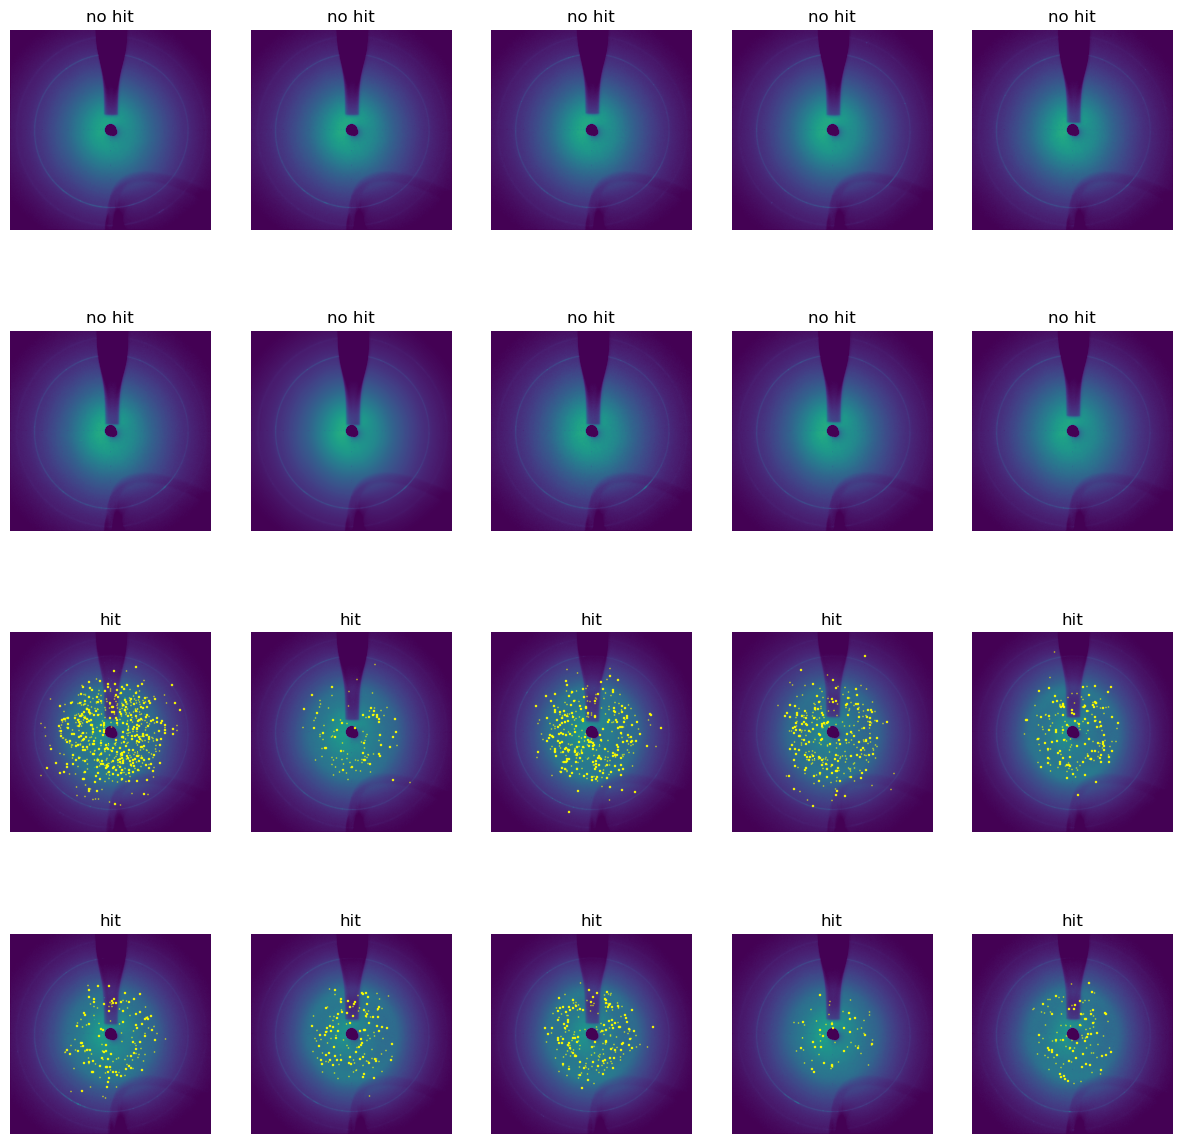

In [7]:
min_num_peaks = 15

ncols = 5
nrows = 4
fig   = plt.figure(figsize = (15,15))
gspec = fig.add_gridspec( nrows, ncols,
                          #width_ratios  = [1/2, 1/2, 1/2, 1/2, 1/2, 1/2, 1/20],
                          #height_ratios = [1/2, 1/2], 
                        )
ax_list = [ fig.add_subplot(gspec[i, j], aspect = 1) for i in range(nrows) for j in range(ncols)]

for row_idx in range(nrows):
    for col_idx in range(ncols):
        idx = row_idx * ncols + col_idx
        ax = ax_list[idx]

        # Stop visualizing when there's no image to process???
        if not idx < len(img_list): break

        img = img_list[idx]
        size_y, size_x = img.shape[-2:]
        img = torch.tensor(img).type(dtype=torch.float)[None,None].to(device)
        
        time_start = time.monotonic()
        peak_list = pf.find_peak_w_softmax(img, min_num_peaks = min_num_peaks, uses_geom = False, returns_prediction_map = False, uses_mixed_precision = True)
        time_end = time.monotonic()
        print(f"Elapsed (peak finding): {(time_end - time_start) * 1e3} ms.")

        # Plot image
        data = img[0, 0].cpu().detach().numpy()
        vmin = np.mean(data) - 1 * data.std()
        vmax = np.mean(data) + 6 * data.std()
        im = ax.imshow(data, vmin = vmin, vmax = vmax)

        # Place a box on a peak
        offset = 3
        b_offset = 2
        for _, y, x in peak_list:
            x_bottom_left = x - offset
            y_bottom_left = y - offset

            rec_obj = mpatches.Rectangle((x_bottom_left, y_bottom_left),
                                         2 * offset, 2 * offset, 
                                         linewidth = 1.0, 
                                         edgecolor = 'yellow', 
                                         facecolor='none')
            ax.add_patch(rec_obj)

        y_bmin, x_bmin = 0, 0
        y_bmax, x_bmax = size_y, size_x
        ax.set_xlim([x_bmin - b_offset, x_bmax + b_offset])
        ax.set_ylim([y_bmin - b_offset, y_bmax + b_offset])
        ax.invert_yaxis()
        
        ax.set_title("hit" if is_hit[idx] else "no hit")

# Apply style...
for ax in ax_list:
    ax.set_xticks([])
    ax.set_yticks([])

    # Hide the frame box
    ax.spines['top'   ].set_visible(False)
    ax.spines['right' ].set_visible(False)
    ax.spines['left'  ].set_visible(False)
    ax.spines['bottom'].set_visible(False)